# Target: 'Type' classes: [Verb,Noun]: Training 3 models :two custom bilstms, normal Bilstm

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from tensorflow.keras.layers import Input,LSTM,Bidirectional,Dense,BatchNormalization,Activation,MaxPooling2D,Dropout,Reshape,Conv2D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import F1Score , Precision , Accuracy, BinaryAccuracy,Recall , AUC
import cv2

2024-12-21 17:37:51.051742: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-21 17:37:51.051889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-21 17:37:51.172564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Confuguration


In [2]:
TARGET_TYPE='Type'
CLASS_NAMES=['verb','noun']
NB_CLASSES=len(CLASS_NAMES)
EPOCHS=120
LR=1e-3
LOSS_FUNCTION='binary_crossentropy'
IMAGE_SHAPE=(256,64,3)
GRAY_SCALING=False

GRAD_CAM_LAYER='max3'

In [3]:
#metrics
f1_score=F1Score()
precision = Precision()
recall =Recall()
binary_accuracy=BinaryAccuracy()
# accuracy = Accuracy()
metrics=[f1_score,precision,recall,'accuracy',binary_accuracy]

class_position_in_path=6

In [4]:
print(tf.__version__)

2.15.0


In [5]:
def get_paths(parent_folder):
    import os
    files={}
    for i in os.walk(parent_folder):
        if i[-1]:
            files[i[0]]=[]
            image_name= i[-1][0]
#             files[i[0]].append(image_name)
            for image_name in i[-1]:
                files[i[0]].append(image_name)
    paths=[]
    for parent_path  in files.keys() :
        for image_name in files[parent_path]:
            paths.append(os.path.join(parent_path,image_name))
    return paths

def remove_not_image_files(paths):
    for p in paths:
        if not p.endswith('.png') and  not p.endswith('.jpg') and not p.endswith('.jpeg'):
            paths.remove(p)

In [6]:
def preprocess_paths(parent_path):
    paths=get_paths(parent_path)
    n_paths_before=len(paths)
    remove_not_image_files(paths)
    n_paths_after=len(paths)
    print(f"{n_paths_before - n_paths_after} paths have been removed from {n_paths_before}")
    return paths

In [7]:
parent_folder ='/kaggle/input/5-arabic-roots/corpus1'
paths=preprocess_paths(parent_folder)

1 paths have been removed from 1045


In [8]:
def get_ref_from_path(path,folder_position):
    if  path.startswith('/'):
        folder_position= folder_position+1
    return path.split('/')[folder_position]

In [9]:

def get_refs_from_paths(paths,folder_position):
    labels=[]
    for path in paths:
        labels.append(get_ref_from_path(path,folder_position))
    return labels

In [10]:
paths[1]

'/kaggle/input/5-arabic-roots/corpus1/0/2/6_pr�sent/10_moukhatab/2_antouma/Image_18_Arabic Transparent_15472.png'

## Choosing the target

### Target: AL-SARF'

In [11]:
refs=get_refs_from_paths(paths,class_position_in_path)

# prepare dataframe:

In [12]:
d = {'path': paths, 'ref':refs}
df =pd.DataFrame.from_dict(d)

In [13]:
df

,path,ref
0,/kaggle/input/5-arabic-roots/corpus1/0/2/6_pr�...,6_pr�sent
1,/kaggle/input/5-arabic-roots/corpus1/0/2/6_pr�...,6_pr�sent
2,/kaggle/input/5-arabic-roots/corpus1/0/2/6_pr�...,6_pr�sent
3,/kaggle/input/5-arabic-roots/corpus1/0/2/6_pr�...,6_pr�sent
4,/kaggle/input/5-arabic-roots/corpus1/0/2/6_pr�...,6_pr�sent
...,...,...
1039,/kaggle/input/5-arabic-roots/corpus1/76/3/5_pa...,5_pass�
1040,/kaggle/input/5-arabic-roots/corpus1/76/3/5_pa...,5_pass�
1041,/kaggle/input/5-arabic-roots/corpus1/76/3/5_pa...,5_pass�
1042,/kaggle/input/5-arabic-roots/corpus1/76/3/5_pa...,5_pass�


In [14]:
df['ref'].value_counts()

ref
5_pass�      396
6_pr�sent    381
nom          242
2             17
1              8
Name: count, dtype: int64

In [15]:
df['ref'].value_counts().index

Index(['5_pass�', '6_pr�sent', 'nom', '2', '1'], dtype='object', name='ref')

In [16]:
verb=['5_pass�','6_pr�sent']
noun=['nom']

# Select necessary words. 

In [17]:
df=df[df['ref'].isin(verb+noun)]
df['ref'].value_counts()

ref
5_pass�      396
6_pr�sent    381
nom          242
Name: count, dtype: int64

# Add gender ref column

In [18]:
df['ref0'] = df['ref']
df['ref'] = df['ref0'].map(lambda x: 'verb' if x in verb else 'noun')

/tmp/ipykernel_26/2654237499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ref0'] = df['ref']
/tmp/ipykernel_26/2654237499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ref'] = df['ref0'].map(lambda x: 'verb' if x in verb else 'noun')


In [19]:
df['ref'].value_counts()

ref
verb    777
noun    242
Name: count, dtype: int64

In [20]:
def ref_to_label(refs:list):
    classes=sorted(list(set(refs)))
    labels = []
    for ref in refs:
        labels.append(str(classes.index(ref)))
    return labels
def prepare_dataframe(paths,refs):
    """
    Role:
        - Prepare dataframe  that conatains the paths of the images and its corresponding labels.
    Inputs:
        - paths : list()
        - labels: list()
    Outputs:
        df : pd.Dataframe()
    """
    import pandas as pd
    labels = ref_to_label(refs)
    d = {'path': paths, 'ref':refs,'label':labels}
    df =pd.DataFrame.from_dict(d)
    return df
# test:
df =prepare_dataframe(df.path.values,df.ref.values)
df

,path,ref,label
0,/kaggle/input/5-arabic-roots/corpus1/0/2/6_pr�...,verb,1
1,/kaggle/input/5-arabic-roots/corpus1/0/2/6_pr�...,verb,1
2,/kaggle/input/5-arabic-roots/corpus1/0/2/6_pr�...,verb,1
3,/kaggle/input/5-arabic-roots/corpus1/0/2/6_pr�...,verb,1
4,/kaggle/input/5-arabic-roots/corpus1/0/2/6_pr�...,verb,1
...,...,...,...
1014,/kaggle/input/5-arabic-roots/corpus1/76/3/5_pa...,verb,1
1015,/kaggle/input/5-arabic-roots/corpus1/76/3/5_pa...,verb,1
1016,/kaggle/input/5-arabic-roots/corpus1/76/3/5_pa...,verb,1
1017,/kaggle/input/5-arabic-roots/corpus1/76/3/5_pa...,verb,1


In [21]:
df['label'].value_counts()

label
1    777
0    242
Name: count, dtype: int64

# Exploaratory data analysis

## Class Distribution 

In [22]:
#plot function
def show_plot(path):
    import matplotlib.pyplot as plt
    img = plt.imread(path)
    plt.imshow(img)

In [23]:
#plot function
def plot_distribution(classe_names,distribution,subset_name):
    plt.style.use('seaborn-dark-palette')
    classes=classe_names
    values =distribution
    plt.figure(figsize = (10, 5))
    plt.bar(classes, values,width = 0.7)

    plt.xlabel("Root id")
    plt.ylabel("Nb. words")
    plt.title(f"Repartition of {sum(values)} words in the {subset_name} data")
    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i, y[i], y[i], ha = 'center',color='black',style='italic',size="x-large")
    addlabels(classes,values)

In [24]:
series = df['ref'].value_counts()
values= series.values
keys = series.index

In [25]:
keys

Index(['verb', 'noun'], dtype='object', name='ref')

/tmp/ipykernel_26/1699016645.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


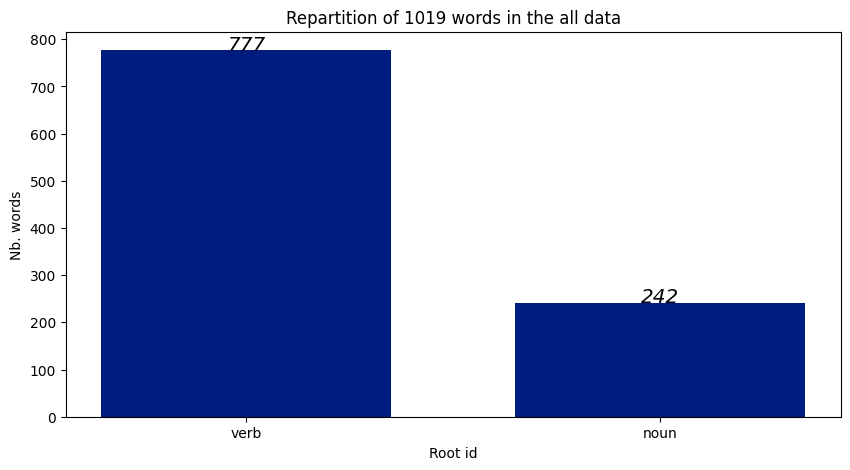

In [26]:
plot_distribution(keys,values,'all')

# split data :train ,test ,val

In [27]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.2,shuffle=True,stratify=df['label'])
# val_df,test_df = train_test_split(test_df,test_size=0.5,shuffle=True,stratify=test_df['label'])

# Train distribution after over sampling

In [28]:
train_series = train_df['ref'].value_counts()
train_values = train_series.values
train_keys = train_series.index

/tmp/ipykernel_26/1699016645.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


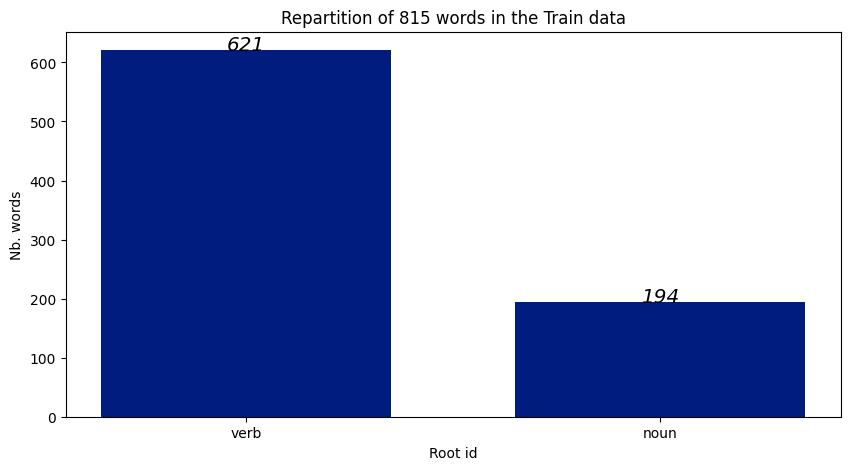

In [29]:
plot_distribution(train_keys,train_values,'Train')

# Test data

In [30]:
test_series = test_df['ref'].value_counts()
test_values = test_series.values
test_keys = test_series.index

/tmp/ipykernel_26/1699016645.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


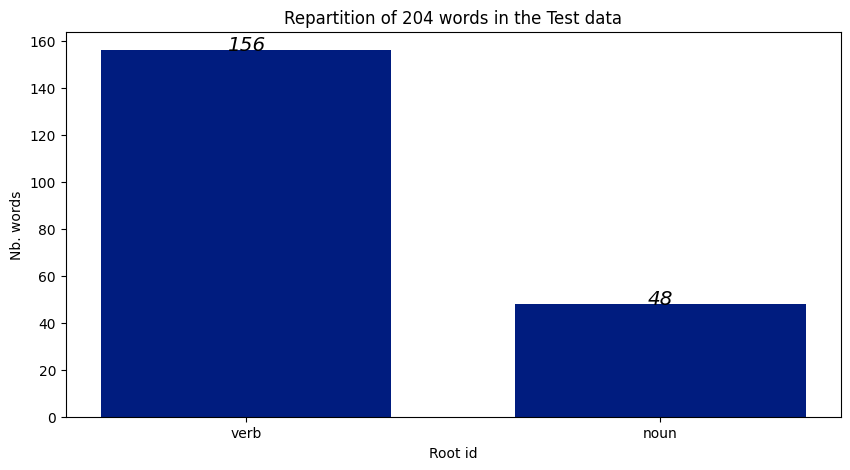

In [31]:
plot_distribution(test_keys,test_values,'Test')

## Load images and prepare lables

In [32]:
def reshape_image(img):
    import cv2
    import numpy as np
    (h, w,d) = img.shape
    
    final_img = np.ones([64, 256,3])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
        
    final_img[:h,:w,:d] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

def prepare_images(paths):
    import cv2
    import numpy as np
    images=[]
    for path in paths:
        if(GRAY_SCALING):
            im = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        else:
            im = cv2.imread(path)
        im = reshape_image(im)
        im = im/255.
        images.append(im)
    print(f"found {len(images)} images with {im.shape} shapes")
    return images

In [33]:
def prepare_xy(paths,labels):
    x = prepare_images(paths)
    y = tf.keras.utils.to_categorical(labels)
    return x ,y

In [34]:
im = cv2.imread(paths[0])
print(im.shape)

(39, 104, 3)


# Train data

In [35]:
X_train,y_train = prepare_xy(train_df['path'],train_df['label']) 
X_train = np.array(X_train).reshape((-1,)+IMAGE_SHAPE)
np.array(X_train).shape

found 815 images with (256, 64, 3) shapes


(815, 256, 64, 3)

# Test DATA

In [36]:
X_test,y_test =prepare_xy(test_df['path'],test_df['label']) 
X_test = np.array(X_test).reshape((-1,)+IMAGE_SHAPE)
X_test.shape

found 204 images with (256, 64, 3) shapes


(204, 256, 64, 3)

# Training

In [37]:

@tf.keras.utils.register_keras_serializable(package="Custom")
class MyLSTM(tf.keras.layers.Layer):
    def __init__(self,units,return_sequences=False, **kwargs):
        super(MyLSTM, self).__init__(**kwargs)
        self.units=units
        self.return_sequences = return_sequences
        self.kernel_size=3
        self.nb_channels= 1
        self.filters=units
        self.cnn_strides=2
        self.cnn_padding='SAME'

        self.lambda_param=0.1 #  this coeff indicates how match we add to the cell memory of the extacted space features with embeded cnns 
        
    def build(self,input_shape):
        nb_features=input_shape[-1]
        self.input_dim = input_shape[-1]
        self.wi= self.add_weight(shape=(self.units,self.units),initializer="glorot_uniform",name="wi")
        self.ui= self.add_weight(shape=(nb_features,self.units),initializer="orthogonal", name="ui")
        self.bi= self.add_weight(shape=(self.units,) , initializer="zeros",name="bi")

        self.wf= self.add_weight(shape=(self.units,self.units),initializer="glorot_uniform",name="wf")
        self.uf= self.add_weight(shape=(nb_features,self.units),initializer="orthogonal", name="uf")
        self.bf= self.add_weight(shape=(self.units,) , initializer="zeros",name="bf")

        self.wc= self.add_weight(shape=(self.units,self.units),initializer="glorot_uniform",name="wc")
        self.uc= self.add_weight(shape=(nb_features,self.units),initializer="orthogonal", name="uc")
        self.bc= self.add_weight(shape=(self.units,) , initializer="zeros",name="bc")

        self.wo= self.add_weight(shape=(self.units,self.units),initializer="glorot_uniform",name="wo")
        self.uo= self.add_weight(shape=(nb_features,self.units),initializer="orthogonal", name="uo")
        self.bo= self.add_weight(shape=(self.units,) , initializer="zeros",name="bo")    

        if(len(input_shape)==4):
            self.nb_channels=input_dim[-1]
            
        self.wcnn = self.add_weight(shape=(self.kernel_size,self.kernel_size,self.nb_channels,self.filters),initializer="glorot_uniform",name="lstm_kernel")
        self.bcnn = self.add_weight(shape=(self.filters,),initializer="zeros",name="ltsm_kernel_bias")


    def convolutional_operation(self,inputs):
        # Perform the convolution operation
        output = tf.nn.conv2d(
            inputs,
            filters=self.wcnn,
            strides=self.cnn_strides,
            padding=self.cnn_padding  # TensorFlow expects 'VALID' or 'SAME'
        )
        
        # Add the bias
        output = tf.nn.bias_add(output, self.bcnn)
        return tf.tanh(output) 
    
    def call(self,inputs):
        timesteps = inputs.shape[1]
        batch_size = tf.shape(inputs)[0]
        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))
        # z = tf.zeros((self.units,self.units))
        # zu = tf.zeros((self.input_dim,self.units))
        state=[h,c]
        outputs=[]
        conv_input = tf.reshape(inputs,[tf.shape(inputs)[0],tf.shape(inputs)[1],tf.shape(inputs)[2],1])        
        space_features = self.convolutional_operation(conv_input)
        space_features = tf.reduce_sum(space_features,axis=2) # (batch_size,timesteps,feature_size,nb_filters) =>(batch_size,timesteps,nb_filters)
        space_features =tf.reduce_sum(space_features,axis=1) # (batch_size,timesteps,nb_filters) => (batch_size,nb_filters)
        for t in range(timesteps):
            xt = inputs[:,t,:]
            ht_1=  tf.reshape(state[0], [-1, self.units])
            ct_1= state[1]
            i = tf.sigmoid(tf.matmul(ht_1,self.wi) +tf.matmul(xt,self.ui)+self.bi)
            f = tf.sigmoid(tf.matmul(ht_1,self.wf) + tf.matmul(xt,self.uf)+ self.bf)
            c_hat = tf.tanh(tf.matmul(ht_1,self.wc)+ tf.matmul(xt,self.uc) + self.bc)
            o = tf.sigmoid(tf.matmul(ht_1,self.wo)+tf.matmul(xt,self.uo) + self.bo)

            # ct = ct_1*f + i*c_hat + tf.tanh(space_features)
            ct = ct_1*f + i*c_hat + self.lambda_param*tf.tanh(space_features)
            
            ht = o*tf.tanh(ct)
            if self.return_sequences:
                outputs.append(ht)
            state=[ht,ct]

        if self.return_sequences:
            return tf.stack(outputs,axis=1)

        else: 
            return state[0]

In [38]:
import tensorflow as tf
@tf.keras.utils.register_keras_serializable(package="Custom1")
class MyBidirectional(tf.keras.layers.Layer):
    def __init__(self, layer, **kwargs):
        super(MyBidirectional, self).__init__(**kwargs)
        self.forward_layer = layer
        self.backward_layer = layer
        self.merge_mode = "concat"  # Can be changed to sum, mul, etc.

    def build(self, input_shape):
        pass
        # Both forward and backward layers are built in the custom LSTM.
        # self.forward_layer.build(input_shape)
        # self.backward_layer.build(input_shape)

    def call(self, inputs):
        # Forward pass
        forward_output = self.forward_layer(inputs)
        
        # Reverse the input for the backward pass
        reversed_inputs = tf.reverse(inputs, axis=[1])
        
        # Backward pass
        backward_output = self.backward_layer(reversed_inputs)
        
        # Reverse the backward output to align it with the forward output
        backward_output = tf.reverse(backward_output, axis=[1])

        if self.merge_mode == "concat":
            output = tf.concat([forward_output, backward_output], axis=-1)
        else:
            # Handle other merge modes here (sum, mul, etc.)
            output = forward_output + backward_output

        return output

In [39]:
input_data = Input(shape=IMAGE_SHAPE, name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.1)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.1)(inner)

# CNN to RNN
inner = Reshape(target_shape=(64,1024), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

##  Bidirectional lstm from scratch : 
inner = MyBidirectional(MyLSTM(256, return_sequences=True), name = 'c_bilstm1_cnn')(inner)
inner = MyBidirectional(MyLSTM(256, return_sequences=False), name = 'c_bilstm2_cnn')(inner)

inner = Dense(1000, activation='relu', kernel_initializer='he_normal', name='dense2')(inner)
## OUTPUT
inner = Dense(NB_CLASSES, kernel_initializer='he_normal',name='dense3')(inner)
y_pred = Activation('sigmoid', name='sigmoid')(inner)
model0 = Model(inputs=input_data, outputs=y_pred)
model0.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 64, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 64, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c_bilstm1_cnn (MyBidirectional) │ (None, 64, 512)        │       331,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c_bilstm2_cnn (MyBidirectional) │ (None, 512)            │       790,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 1000)           │       513,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 2)              │         2,002 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid (Activation)            │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,796,026 (6.85 MB)

 Trainable params: 1,795,578 (6.85 MB)

 Non-trainable params: 448 (1.75 KB)

In [40]:
@tf.keras.utils.register_keras_serializable(package="Custom2")
class MyLSTM(tf.keras.layers.Layer):
    def __init__(self,units,return_sequences=False, **kwargs):
        super(MyLSTM, self).__init__(**kwargs)
        self.units=units
        self.return_sequences = return_sequences
        self.kernel_size=3
        self.nb_channels= 1
        self.filters=units
        self.cnn_strides=2
        self.cnn_padding='SAME'
        
    def build(self,input_shape):
        nb_features=input_shape[-1]
        self.input_dim = input_shape[-1]

        ## Weights of the first lstm layer
        
        self.wi= self.add_weight(shape=(self.units,self.units),initializer="glorot_uniform",name="wi")
        self.ui= self.add_weight(shape=(nb_features,self.units),initializer="orthogonal", name="ui")
        self.bi= self.add_weight(shape=(self.units,) , initializer="zeros",name="bi")

        self.wf= self.add_weight(shape=(self.units,self.units),initializer="glorot_uniform",name="wf")
        self.uf= self.add_weight(shape=(nb_features,self.units),initializer="orthogonal", name="uf")
        self.bf= self.add_weight(shape=(self.units,) , initializer="zeros",name="bf")

        self.wc= self.add_weight(shape=(self.units,self.units),initializer="glorot_uniform",name="wc")
        self.uc= self.add_weight(shape=(nb_features,self.units),initializer="orthogonal", name="uc")
        self.bc= self.add_weight(shape=(self.units,) , initializer="zeros",name="bc")

        self.wo= self.add_weight(shape=(self.units,self.units),initializer="glorot_uniform",name="wo")
        self.uo= self.add_weight(shape=(nb_features,self.units),initializer="orthogonal", name="uo")
        self.bo= self.add_weight(shape=(self.units,) , initializer="zeros",name="bo")    

        ## Weights of the second lstm layer

        self.wi2= self.add_weight(shape=(self.units,self.units),initializer="glorot_uniform",name="wi2")
        self.ui2= self.add_weight(shape=(nb_features,self.units),initializer="orthogonal", name="ui2")
        self.bi2= self.add_weight(shape=(self.units,) , initializer="zeros",name="bi2")

        self.wf2= self.add_weight(shape=(self.units,self.units),initializer="glorot_uniform",name="wf2")
        self.uf2= self.add_weight(shape=(nb_features,self.units),initializer="orthogonal", name="uf2")
        self.bf2= self.add_weight(shape=(self.units,) , initializer="zeros",name="bf2")

        self.wc2= self.add_weight(shape=(self.units,self.units),initializer="glorot_uniform",name="wc2")
        self.uc2= self.add_weight(shape=(nb_features,self.units),initializer="orthogonal", name="uc2")
        self.bc2= self.add_weight(shape=(self.units,) , initializer="zeros",name="bc2")

        self.wo2= self.add_weight(shape=(self.units,self.units),initializer="glorot_uniform",name="wo2")
        self.uo2= self.add_weight(shape=(nb_features,self.units),initializer="orthogonal", name="uo2")
        self.bo2= self.add_weight(shape=(self.units,) , initializer="zeros",name="bo2")    

    def call(self,inputs):
        timesteps = inputs.shape[1]
        batch_size = tf.shape(inputs)[0]
        ht = tf.zeros((batch_size, self.units))
        ct = tf.zeros((batch_size, self.units))
        hn_t = tf.zeros((batch_size, self.units))
        cn_t = tf.zeros((batch_size, self.units))
        state=[ht,ct,hn_t,cn_t]
        outputs=[]
        for t in range(timesteps):
            ht_1=  tf.reshape(ht, [-1, self.units])
            ct_1= state[1]
            hn_t_1=  tf.reshape(hn_t, [-1, self.units])
            cn_t_1= state[3]

            # forward
            xt = inputs[:,t,:]
            i = tf.sigmoid(tf.matmul(ht_1,self.wi) +tf.matmul(xt,self.ui)+self.bi)
            f = tf.sigmoid(tf.matmul(ht_1,self.wf) + tf.matmul(xt,self.uf)+ self.bf)
            c_hat = tf.tanh(tf.matmul(ht_1,self.wc)+ tf.matmul(xt,self.uc) + self.bc)
            o = tf.sigmoid(tf.matmul(ht_1,self.wo)+tf.matmul(xt,self.uo) + self.bo)
            ct = ct_1*f + i*c_hat
            ht = o*tf.tanh(ct)

            #backword
            xn_t = inputs[:,timesteps - t - 1,:]
            in_t = tf.sigmoid(tf.matmul(hn_t_1,self.wi2) +tf.matmul(xn_t,self.ui2)+self.bi2)
            fn_t = tf.sigmoid(tf.matmul(hn_t_1,self.wf2) + tf.matmul(xn_t,self.uf2)+ self.bf2)
            cn_t_hat = tf.tanh(tf.matmul(hn_t_1,self.wc2)+ tf.matmul(xn_t,self.uc2) + self.bc2)
            on_t = tf.sigmoid(tf.matmul(hn_t_1,self.wo2)+tf.matmul(xn_t,self.uo2) + self.bo2)
            cn_t = cn_t_1*fn_t + in_t*cn_t_hat
            hn_t = on_t*tf.tanh(cn_t)
            
            if self.return_sequences:
                outputs.append(tf.concat([ht,hn_t],axis=1))
            state=[ht,ct,hn_t,cn_t]

        if self.return_sequences:
            return tf.stack(outputs,axis=1)

        else: 
            return state[0]

In [41]:
model0.compile(optimizer=Adam(LR),loss=LOSS_FUNCTION,metrics=metrics)

In [42]:
history=model0.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=EPOCHS,verbose=2)

Epoch 1/120


2024-12-21 17:40:42.270870: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7104: 3.46178, expected 3.00983
2024-12-21 17:40:42.270933: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8255: 3.50289, expected 3.05095
2024-12-21 17:40:42.270946: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8896: 3.07815, expected 2.6262
2024-12-21 17:40:42.270965: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11519: 2.60937, expected 2.15743
2024-12-21 17:40:42.270973: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11520: 2.89338, expected 2.44144
2024-12-21 17:40:42.270981: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11583: 2.94119, expected 2.48924
2024-12-21 17:40:42.270989: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11647: 3.3848, expected 2.93285
2024-12-21 17:40:42.271080: E ex

26/26 - 445s - 17s/step - accuracy: 0.7620 - binary_accuracy: 0.7534 - f1_score: 0.4325 - loss: 0.5687 - precision: 0.7438 - recall: 0.7730 - val_accuracy: 0.7647 - val_binary_accuracy: 0.7647 - val_f1_score: 0.4333 - val_loss: 0.5424 - val_precision: 0.7647 - val_recall: 0.7647
Epoch 2/120
26/26 - 2s - 63ms/step - accuracy: 0.7620 - binary_accuracy: 0.7620 - f1_score: 0.4325 - loss: 0.5356 - precision: 0.7620 - recall: 0.7620 - val_accuracy: 0.7647 - val_binary_accuracy: 0.7647 - val_f1_score: 0.4333 - val_loss: 0.5402 - val_precision: 0.7647 - val_recall: 0.7647
Epoch 3/120
26/26 - 2s - 60ms/step - accuracy: 0.7620 - binary_accuracy: 0.7620 - f1_score: 0.4325 - loss: 0.4973 - precision: 0.7620 - recall: 0.7620 - val_accuracy: 0.7647 - val_binary_accuracy: 0.7647 - val_f1_score: 0.4333 - val_loss: 0.5123 - val_precision: 0.7647 - val_recall: 0.7647
Epoch 4/120
26/26 - 2s - 60ms/step - accuracy: 0.7620 - binary_accuracy: 0.7620 - f1_score: 0.4325 - loss: 0.4889 - precision: 0.7620 - re

## Model

In [43]:
input_data = Input(shape=IMAGE_SHAPE, name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.1)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.1)(inner)

# CNN to RNN
inner = Reshape(target_shape=(64,1024), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

##  Bidirectional lstm from scratch : 
inner = MyLSTM(256, return_sequences=True, name = 'c_bilstm1')(inner)
inner = MyLSTM(256, return_sequences=False, name = 'c_bilstm2')(inner)

inner = Dense(1000, activation='relu', kernel_initializer='he_normal', name='dense2')(inner)
## OUTPUT
inner = Dense(NB_CLASSES, kernel_initializer='he_normal',name='dense3')(inner)
y_pred = Activation('sigmoid', name='sigmoid')(inner)
model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 64, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 64, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c_bilstm1 (MyLSTM)              │ (None, 64, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c_bilstm2 (MyLSTM)              │ (None, 256)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 1000)           │       257,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 2)              │         2,002 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid (Activation)            │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651,066 (10.11 MB)

 Trainable params: 2,650,618 (10.11 MB)

 Non-trainable params: 448 (1.75 KB)

In [44]:
model.compile(optimizer=Adam(LR),loss=LOSS_FUNCTION,metrics=metrics)

In [45]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=EPOCHS,verbose=2)

Epoch 1/120


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['wi2', 'ui2', 'bi2', 'wf2', 'uf2', 'bf2', 'wc2', 'uc2', 'bc2', 'wo2', 'uo2', 'bo2'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
W0000 00:00:1734803509.701319      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 - 311s - 12s/step - accuracy: 0.7423 - binary_accuracy: 0.7910 - f1_score: 0.6073 - loss: 0.5709 - precision: 0.7753 - recall: 0.8194 - val_accuracy: 0.7647 - val_binary_accuracy: 0.7647 - val_f1_score: 0.4333 - val_loss: 0.5482 - val_precision: 0.7647 - val_recall: 0.7647
Epoch 2/120
26/26 - 1s - 42ms/step - accuracy: 0.7620 - binary_accuracy: 0.7620 - f1_score: 0.4325 - loss: 0.5543 - precision: 0.7620 - recall: 0.7620 - val_accuracy: 0.7647 - val_binary_accuracy: 0.7647 - val_f1_score: 0.4333 - val_loss: 0.5366 - val_precision: 0.7647 - val_recall: 0.7647
Epoch 3/120
26/26 - 1s - 41ms/step - accuracy: 0.7620 - binary_accuracy: 0.7620 - f1_score: 0.4325 - loss: 0.5302 - precision: 0.7620 - recall: 0.7620 - val_accuracy: 0.7647 - val_binary_accuracy: 0.7647 - val_f1_score: 0.4333 - val_loss: 0.5568 - val_precision: 0.7647 - val_recall: 0.7647
Epoch 4/120
26/26 - 1s - 41ms/step - accuracy: 0.7620 - binary_accuracy: 0.7620 - f1_score: 0.4325 - loss: 0.5011 - precision: 0.7620 - re

# Train model with Bilstm

In [46]:
input_data = Input(shape=IMAGE_SHAPE, name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.1)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.1)(inner)
# input_data=resnet50.input
# output_resent50 = resnet50.output

# CNN to RNN
inner = Reshape(target_shape=(64,1024), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

##  Bidirectional Bilstm from scratch : 
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'bilstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=False), name = 'bilstm2')(inner)
# inner = MyLSTM(256, return_sequences=True, name = 'bilstm1')(inner)
# inner = MyLSTM(256, return_sequences=False, name = 'bilstm2')(inner)

inner = Dense(1000, activation='relu', kernel_initializer='he_normal', name='dense2')(inner)
## OUTPUT
inner = Dense(NB_CLASSES, kernel_initializer='he_normal',name='dense3')(inner)
y_pred = Activation('sigmoid', name='sigmoid')(inner)
model2 = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 64, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 64, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c_bilstm1 (MyLSTM)              │ (None, 64, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c_bilstm2 (MyLSTM)              │ (None, 256)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 1000)           │       257,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 2)              │         2,002 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid (Activation)            │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,952,304 (30.34 MB)

 Trainable params: 2,650,618 (10.11 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 5,301,238 (20.22 MB)

In [47]:
model2.compile(optimizer=Adam(LR),loss=LOSS_FUNCTION,metrics=metrics)

In [48]:
history2=model2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=EPOCHS,verbose=2)

Epoch 1/120


2024-12-21 17:56:37.564661: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


26/26 - 12s - 444ms/step - accuracy: 0.7325 - binary_accuracy: 0.7797 - f1_score: 0.5827 - loss: 0.5936 - precision: 0.7778 - recall: 0.7831 - val_accuracy: 0.7647 - val_binary_accuracy: 0.7647 - val_f1_score: 0.4333 - val_loss: 0.5486 - val_precision: 0.7647 - val_recall: 0.7647
Epoch 2/120
26/26 - 1s - 50ms/step - accuracy: 0.7620 - binary_accuracy: 0.7620 - f1_score: 0.4325 - loss: 0.5506 - precision: 0.7620 - recall: 0.7620 - val_accuracy: 0.7647 - val_binary_accuracy: 0.7647 - val_f1_score: 0.4333 - val_loss: 0.5368 - val_precision: 0.7647 - val_recall: 0.7647
Epoch 3/120
26/26 - 1s - 50ms/step - accuracy: 0.7620 - binary_accuracy: 0.7620 - f1_score: 0.4325 - loss: 0.5348 - precision: 0.7620 - recall: 0.7620 - val_accuracy: 0.7647 - val_binary_accuracy: 0.7647 - val_f1_score: 0.4333 - val_loss: 0.6344 - val_precision: 0.7647 - val_recall: 0.7647
Epoch 4/120
26/26 - 1s - 50ms/step - accuracy: 0.7620 - binary_accuracy: 0.7620 - f1_score: 0.4325 - loss: 0.4976 - precision: 0.7620 - r

# Results

In [49]:
history.history.keys()

dict_keys(['accuracy', 'binary_accuracy', 'f1_score', 'loss', 'precision', 'recall', 'val_accuracy', 'val_binary_accuracy', 'val_f1_score', 'val_loss', 'val_precision', 'val_recall'])

In [50]:
keys=['binary_accuracy','f1_score','loss','precision', 'accuracy','recall']

/tmp/ipykernel_26/2048339708.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


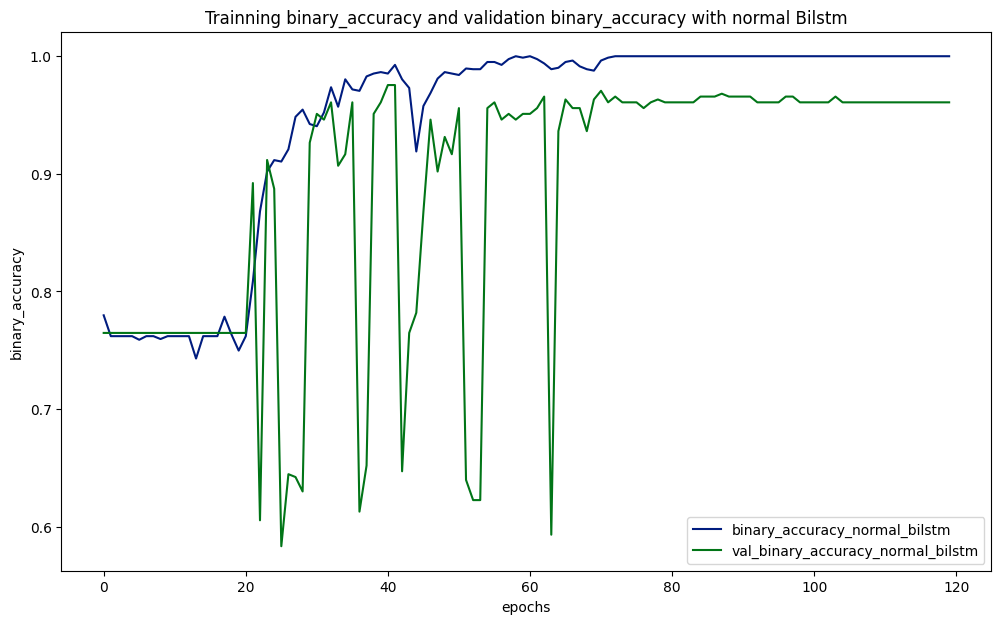

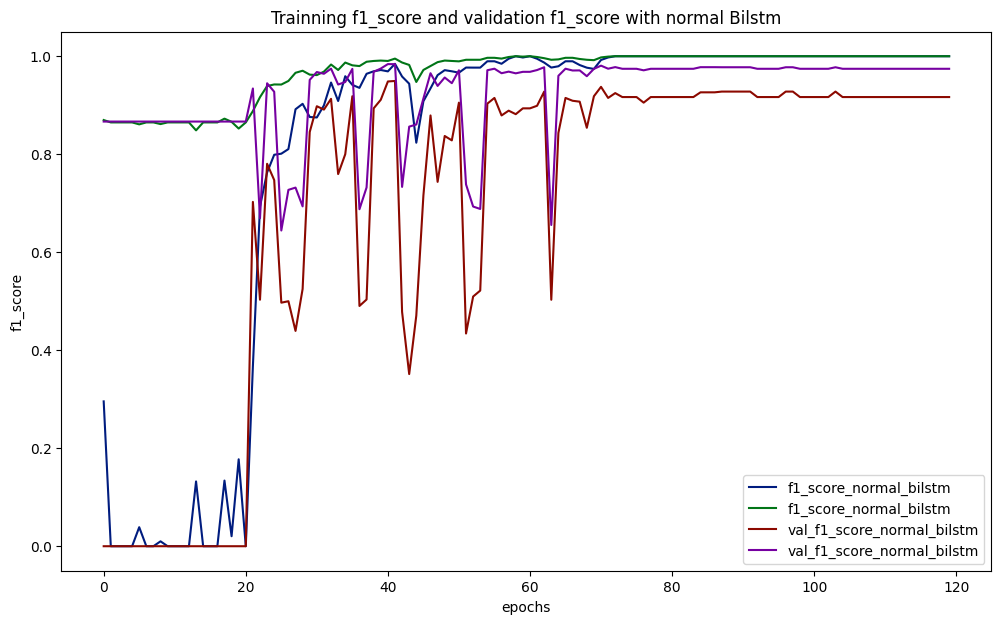

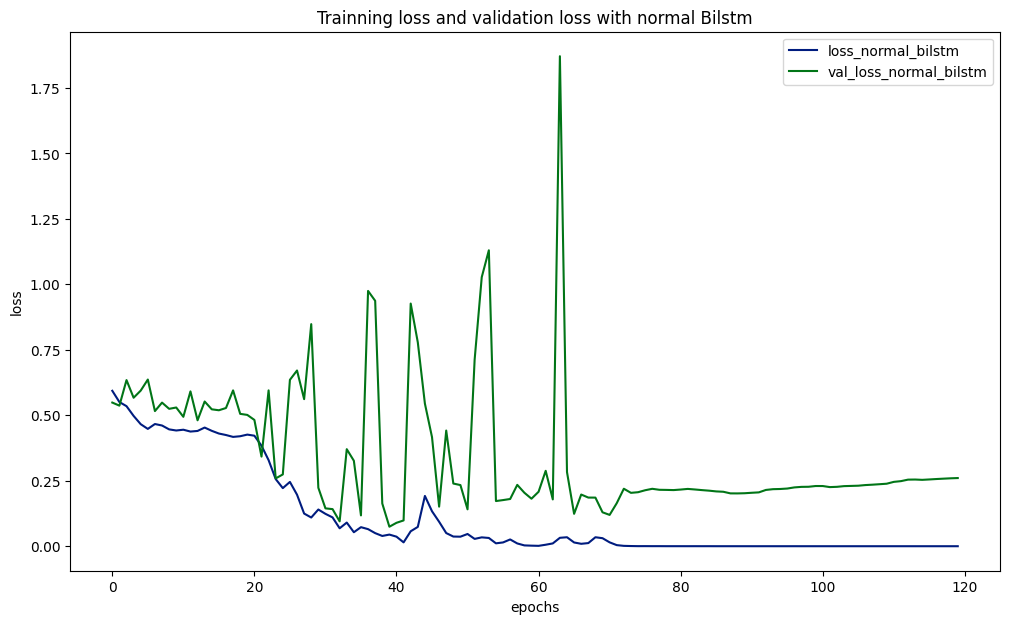

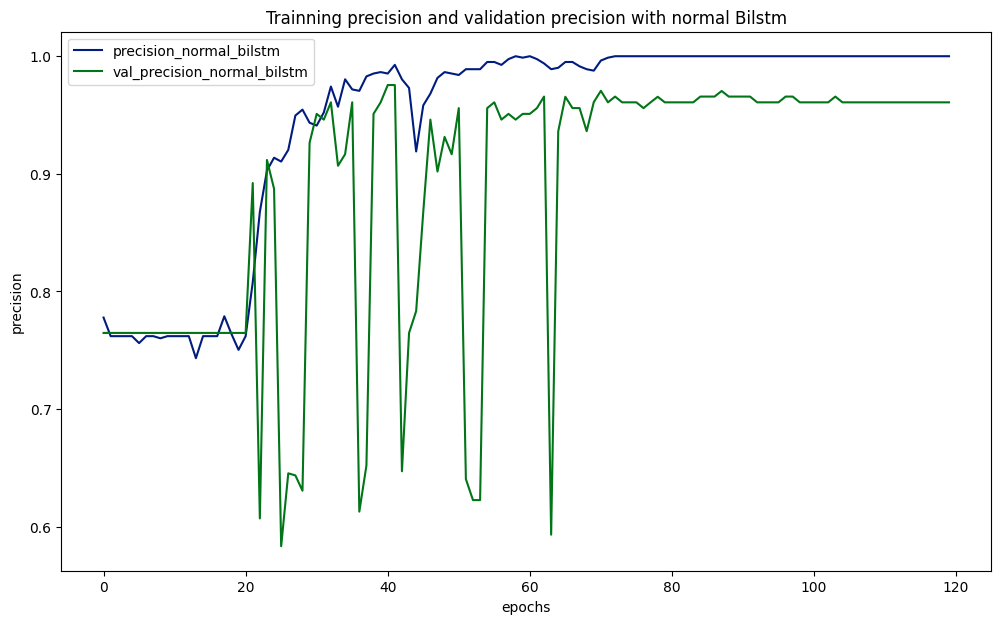

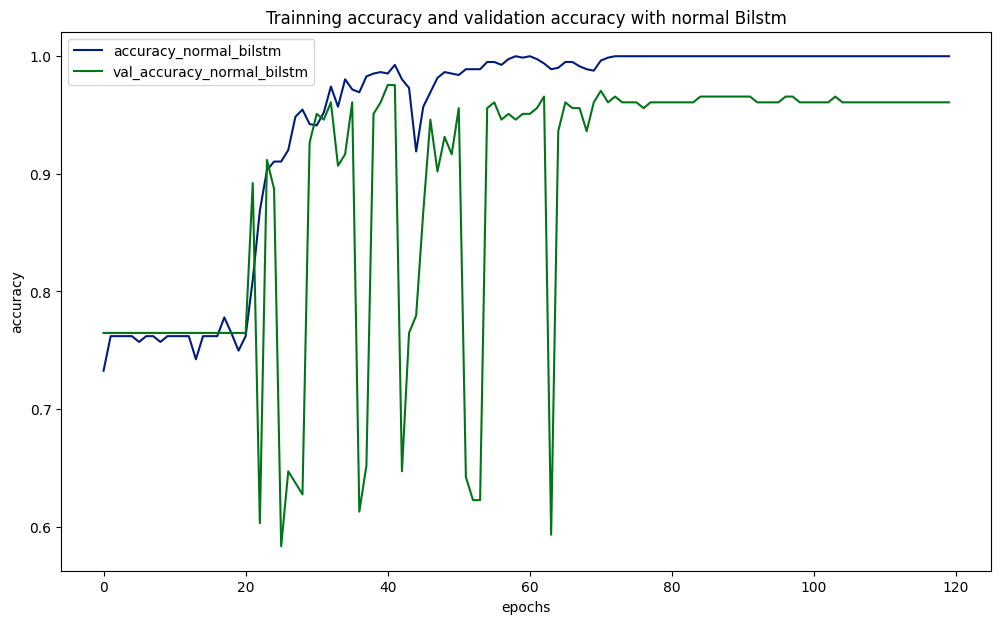

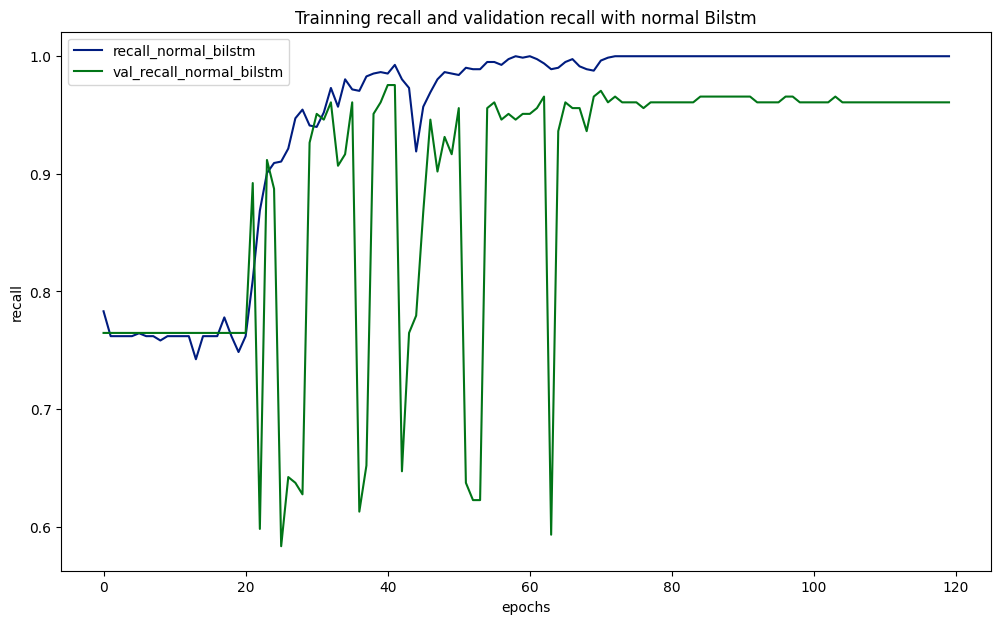

In [51]:
plt.style.use('seaborn-dark-palette')
for key in keys:
    plt.figure(figsize=(12,7))
    plt.plot(history2.history[f'{key}'],label=f'{key}_normal_bilstm')
    plt.legend()
    plt.plot(history2.history[f'val_{key}'],label=f'val_{key}_normal_bilstm')
    plt.legend()
    plt.title(f'Trainning {key} and validation {key} with normal Bilstm')
    plt.xlabel('epochs')
    plt.ylabel(key)

/tmp/ipykernel_26/3830624269.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


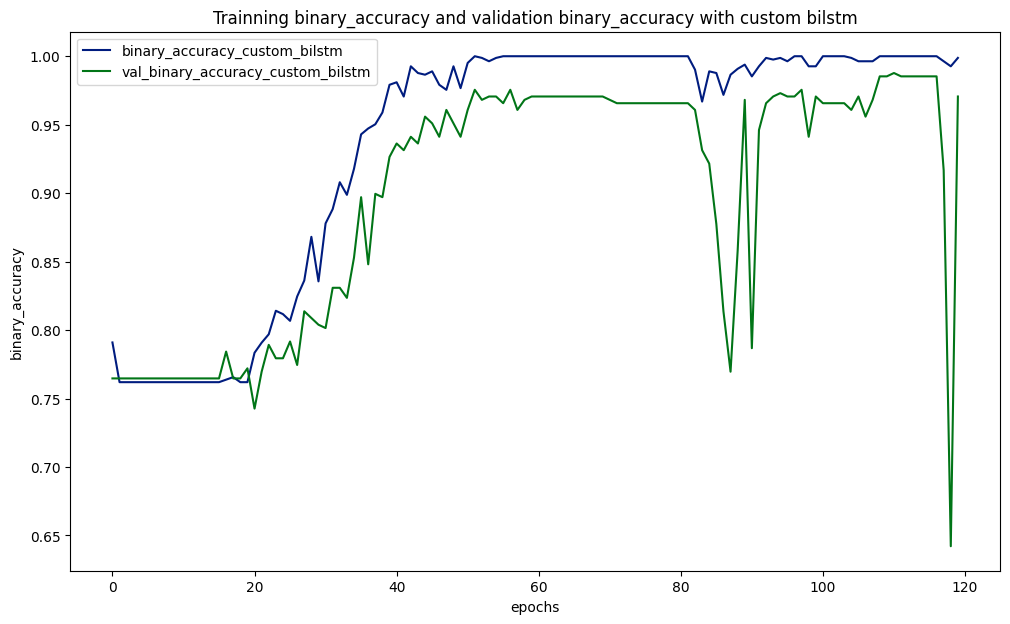

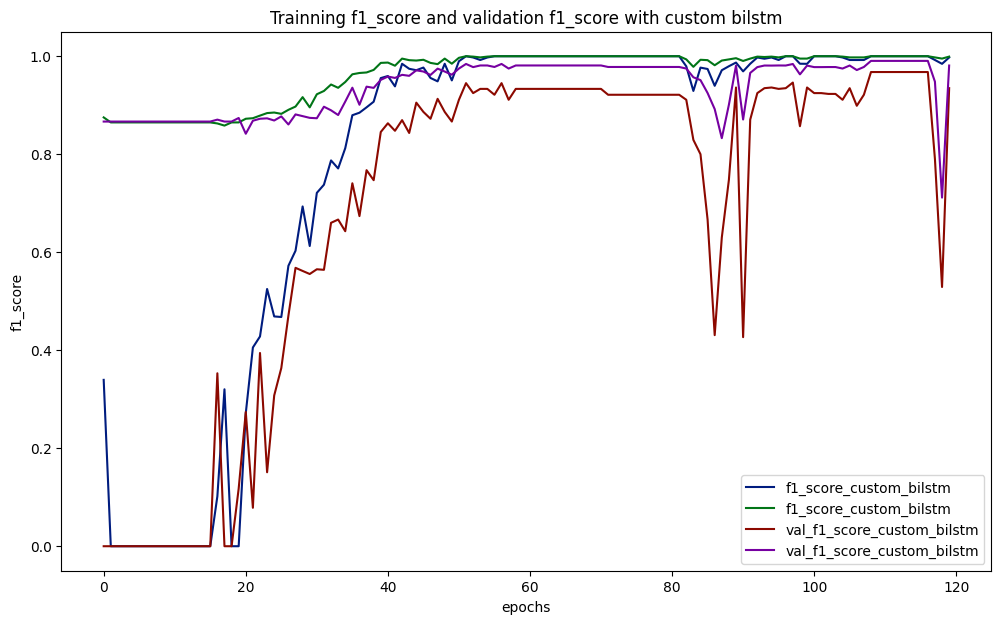

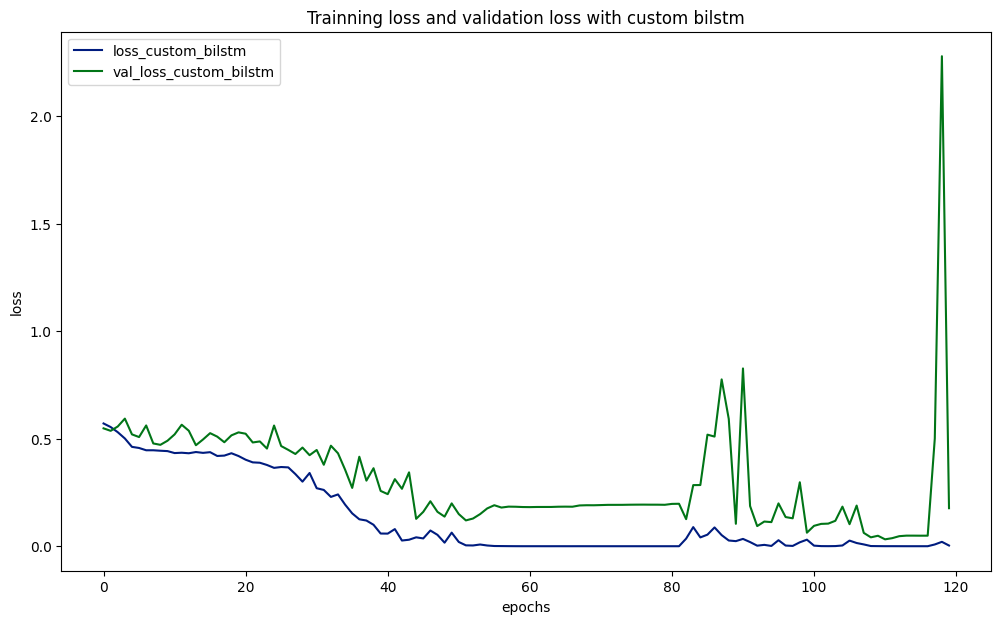

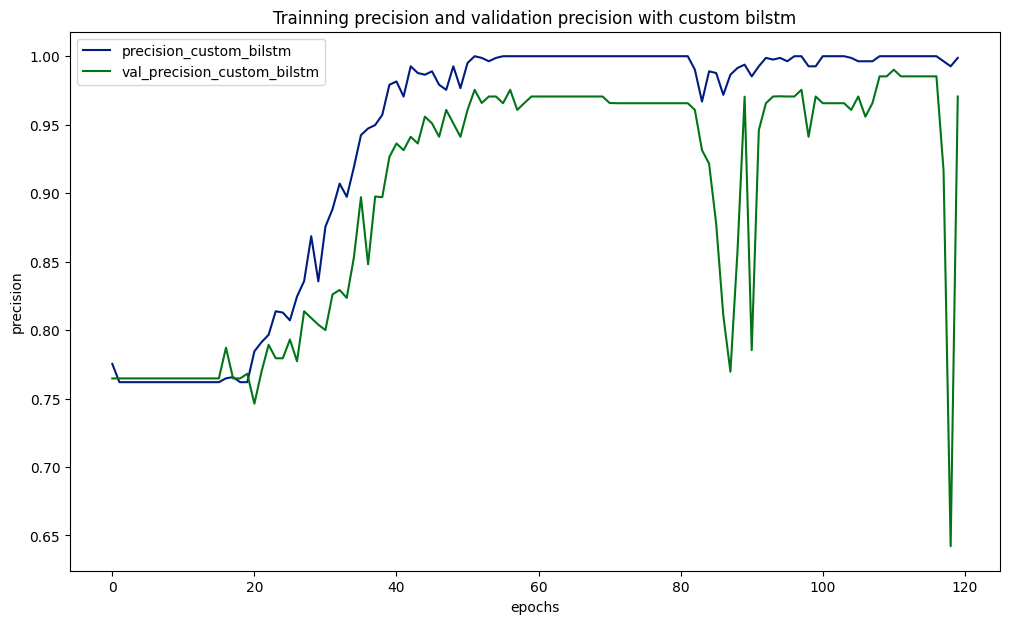

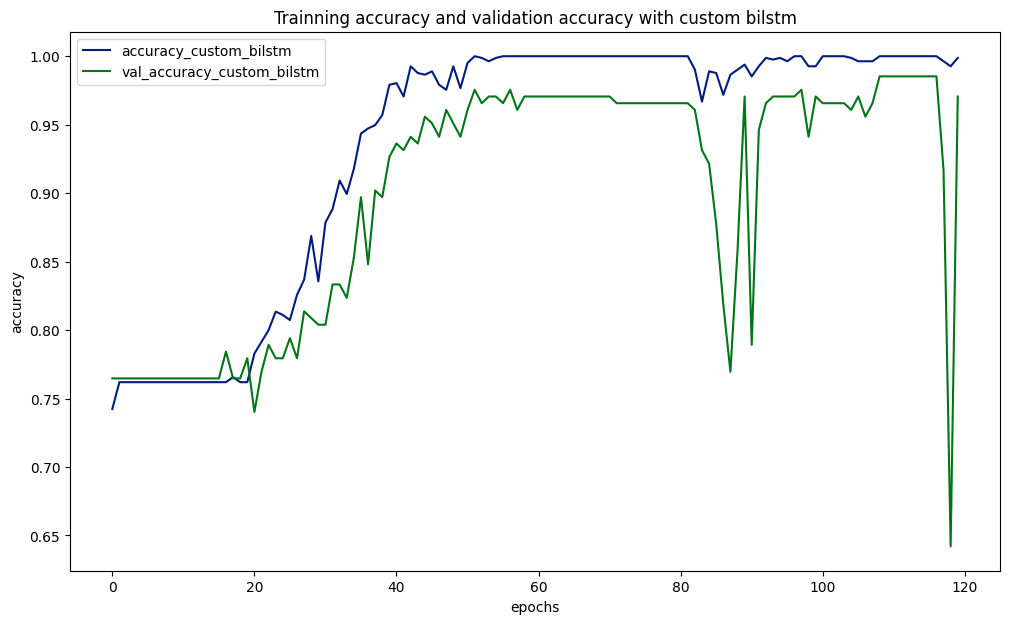

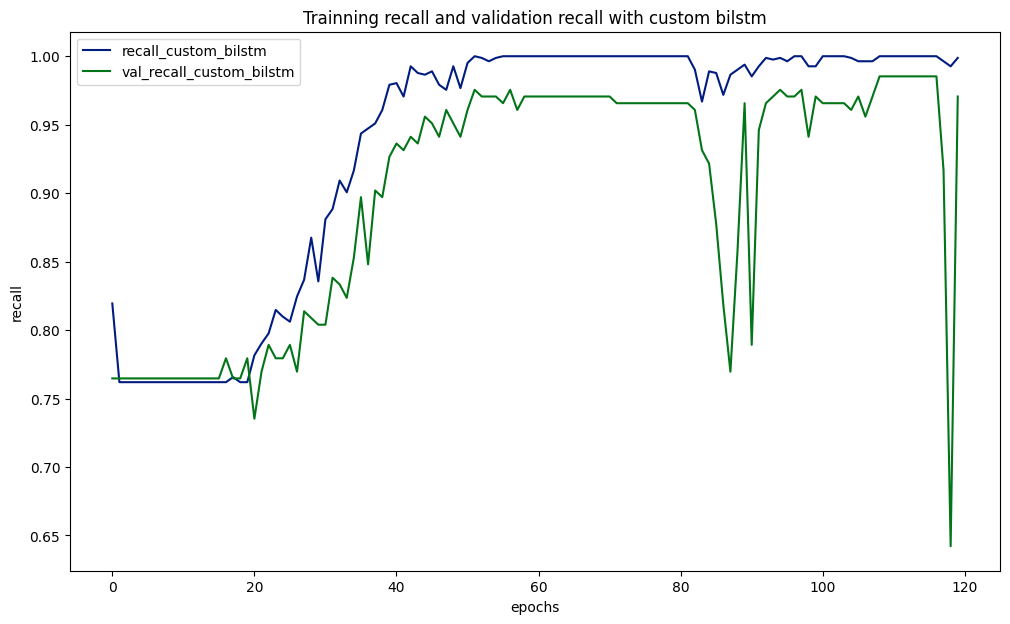

In [52]:
plt.style.use('seaborn-dark-palette')
for key in keys:
    plt.figure(figsize=(12,7))
    plt.plot(history.history[f'{key}'],label=f'{key}_custom_bilstm')
    plt.legend()
    plt.plot(history.history[f'val_{key}'],label=f'val_{key}_custom_bilstm')
    plt.legend()
    plt.title(f'Trainning {key} and validation {key} with custom bilstm')
    plt.xlabel('epochs')
    plt.ylabel(key)

# Predictions results on train data

### Evaluation of the model with Custom lstm cell with embedded CNNs results

In [53]:
res0_train=model0.evaluate(X_train,y_train)
res0_train

26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 1.0000 - binary_accuracy: 1.0000 - f1_score: 1.0000 - loss: 2.1134e-06 - precision: 1.0000 - recall: 1.0000


[2.091172063956037e-06,
 1.0,
 1.0,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
 1.0,
 1.0]

In [54]:
res0_test=model0.evaluate(X_test,y_test)
res0_test

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9799 - binary_accuracy: 0.9799 - f1_score: 0.9739 - loss: 0.1696 - precision: 0.9799 - recall: 0.9799


[0.1527804583311081,
 0.9803921580314636,
 0.9803921580314636,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.95918363, 0.9870967 ], dtype=float32)>,
 0.9803921580314636,
 0.9803921580314636]

### Evaluation of the model with Custom lstm cell as bilstm results

In [55]:
res_train=model.evaluate(X_train,y_train)
res_train

26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 997ms/step - accuracy: 0.9891 - binary_accuracy: 0.9891 - f1_score: 0.9842 - loss: 0.0514 - precision: 0.9891 - recall: 0.9891


[0.04206253960728645,
 0.9889570474624634,
 0.9889570474624634,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9763779, 0.9927942], dtype=float32)>,
 0.9889570474624634,
 0.9889570474624634]

In [56]:
res_test=model.evaluate(X_test,y_test)
res_test

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9635 - binary_accuracy: 0.9635 - f1_score: 0.9501 - loss: 0.2084 - precision: 0.9635 - recall: 0.9635


[0.17682531476020813,
 0.970588207244873,
 0.970588207244873,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.93478256, 0.98101264], dtype=float32)>,
 0.970588207244873,
 0.970588207244873]

### Evaluation of the model with Normal Bilstm Results

In [57]:
res2_train=model2.evaluate(X_train,y_train)
res2_train

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - binary_accuracy: 1.0000 - f1_score: 1.0000 - loss: 2.7660e-06 - precision: 1.0000 - recall: 1.0000


[2.465922534611309e-06,
 1.0,
 1.0,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
 1.0,
 1.0]

In [58]:
res2_test=model2.evaluate(X_test,y_test)
res2_test

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9670 - binary_accuracy: 0.9670 - f1_score: 0.9564 - loss: 0.2437 - precision: 0.9670 - recall: 0.9670


[0.2603362798690796,
 0.9607843160629272,
 0.9607843160629272,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9166666, 0.9743589], dtype=float32)>,
 0.9607843160629272,
 0.9607843160629272]